# 作業 : (Kaggle)鐵達尼生存預測
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著調整特徵篩選的門檻值, 觀察會有什麼影響效果

# [作業重點]
- 調整相關係數過濾法的篩選門檻, 看看篩選結果的影響 (In[5]~In[8], Out[5]~Out[8])
- 調整L1 嵌入法篩選門檻, 看看篩選結果的影響 (In[9]~In[11], Out[9]~Out[11])

In [1]:
# 程式區塊 A
# 將需要的都import進來
import os
import copy
import time
import math
import numpy             as np
import pandas            as pd
import seaborn           as sns
import datetime          as dt
import warnings
import matplotlib.pyplot as plt
from scipy                   import stats
from itertools               import compress
from sklearn.ensemble        import GradientBoostingRegressor
from sklearn.linear_model    import LogisticRegression,LinearRegression,Lasso
from sklearn.preprocessing   import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score

# 將較長的函式改名一下
MME  = MinMaxScaler()
LE   = LabelEncoder()
LR   = LogisticRegression()
LIR  = LinearRegression()
GBR  = GradientBoostingRegressor()
PDDF = pd.DataFrame()
# 一些必要的設定
warnings.filterwarnings('ignore')
%matplotlib inline

# 設定【data的資料夾路徑】，命名為【data_folder】
data_folder = 'C:/Users/Ynitsed/Documents/GitHub/2nd-ML100Days/data'

In [2]:
# 設定t001為某個data路徑
# 設定t002為pd裡read data的功能
t001_train = os.path.join(data_folder, 'titanic_train.csv')
t002_train = pd.read_csv(t001_train)
print('Path of read in data: %s' %t001_train)
print(t002_train.shape)
t002_train.head()

Path of read in data: C:/Users/Ynitsed/Documents/GitHub/2nd-ML100Days/data\titanic_train.csv
(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# 設定t001為某個data路徑
# 設定t002為pd裡read data的功能
t001_test  = os.path.join(data_folder,  'titanic_test.csv')
t002_test  = pd.read_csv(t001_test)
print('Path of read in data: %s' %t001_test)
print(t002_test.shape)
t002_test.head()

Path of read in data: C:/Users/Ynitsed/Documents/GitHub/2nd-ML100Days/data\titanic_test.csv
(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# 程式區塊 B-1：train取【Survived】為Y、test取【PassengerId】為最終將比對的唯一識別
train_Y     = t002_train['Survived']
test_unique = t002_test['PassengerId']
# 程式區塊 B-2：train捨棄【PassengerId,Survived】、test捨棄【PassengerId】。
t003_train = t002_train.drop(['PassengerId', 'Survived'] , axis=1)
t003_test  = t002_test.drop(['PassengerId'] , axis=1)
print(t003_train.shape)
print(t003_test.shape)

(891, 10)
(418, 10)


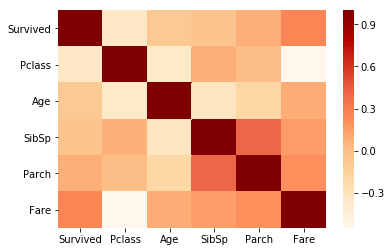

In [5]:
# 計算df整體相關係數, 並繪製成熱圖
corr = t002_train.drop(['PassengerId'] , axis=1).corr()
sns.heatmap(corr,cmap = plt.cm.OrRd)
plt.show()

In [6]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for a, b in zip(t003_train.dtypes, t003_train.columns):
    if a == 'float64' or a == 'int64':
        num_features.append(b)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
t004_train = t003_train[num_features]
t005_train = t004_train.fillna(-1)
print(t005_train.shape)
t005_train.head()

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

(891, 5)


,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


# 作業1
* 鐵達尼生存率預測中，試著變更兩種以上的相關係數門檻值，觀察預測能力是否提升?
> 由上述不同門檻可以發現, 相關係數有時候確實能成功提升準確度, 但篩選過頭會有反效果  
門檻的決定沒有一定的準則, 因此這個方法並不那麼好用

# 吐槽1
欸還是忍不住想吐槽齁，你把4個無相關的變數減成2個，廢話當然解釋度會下降啊！  
這和之前把5個變數變成1個的概念完全不同，因為那1個變數，其實是透過5個變數的其中4個去計算出來的，  
所以縱使只放了1個變數，實際的意義卻是放了4個，而且還是經過整理的4個，所以會有效。  
這應該是這樣看，我將變數從4個減為2個，分數卻只從0.704降成0.679，表示這2個變數是很強的。  
所以這種篩選方法，仍然是有用的。  

In [7]:
# 原始特徵 + 邏輯斯迴歸
train_X = MME.fit_transform(t005_train)
cross_val_score(LR, train_X, train_Y, cv=5).mean()

0.7038635542329971

In [8]:
# 篩選相關係數大於 0.05 或小於 -0.05 的特徵
# | 是 or的意思
high_list = list(corr[(corr['Survived']>0.05) | (corr['Survived']<-0.05)].index)
high_list.pop(0)
print(high_list)

['Pclass', 'Age', 'Parch', 'Fare']


In [9]:
# 0.05特徵 + 邏輯斯迴歸
train_X = MME.fit_transform(t005_train[high_list])
print(train_X.shape)
print(f'Logistic Reg Score : {cross_val_score(LR, train_X, train_Y, cv=5).mean()}')
print(f'Linear Reg Score : {cross_val_score(LIR, train_X, train_Y, cv=5).mean()}')
print(f'Gradient Boosting Reg Score : {cross_val_score(GBR, train_X, train_Y, cv=5).mean()}')

(891, 4)
Logistic Reg Score : 0.7049872206659582
Linear Reg Score : 0.11402839433832561
Gradient Boosting Reg Score : 0.17118299914241378


In [10]:
# 篩選相關係數大於 0.05 或小於 -0.05 的特徵
# | 是 or的意思
high_list_2 = list(corr[(corr['Survived']>0.1) | (corr['Survived']<-0.1)].index)
high_list_2.pop(0)
print(high_list_2)

['Pclass', 'Fare']


In [11]:
# 0.1特徵 + 邏輯斯迴歸
train_X = MME.fit_transform(t005_train[high_list_2])
print(train_X.shape)
print(f'Logistic Reg Score : {cross_val_score(LR, train_X, train_Y, cv=5).mean()}')
print(f'Linear Reg Score : {cross_val_score(LIR, train_X, train_Y, cv=5).mean()}')
print(f'Gradient Boosting Reg Score : {cross_val_score(GBR, train_X, train_Y, cv=5).mean()}')

(891, 2)
Logistic Reg Score : 0.6791567235397566
Linear Reg Score : 0.10227650079409392
Gradient Boosting Reg Score : 0.14300997621701333


# 作業2
* 續上題，使用 L1 Embedding 做特徵選擇(自訂門檻)，觀察預測能力是否提升?
> 在作業與範例中, 效果並不如顯著  
而且與相關係數法類似, L1 Embedding 也需要調整 alpha 值, 且沒有一定法則  
所以也並非好用的特徵篩選方式

In [12]:
from sklearn.linear_model import Lasso
L1_Reg = Lasso(alpha=0.005)
train_X = MME.fit_transform(t005_train)
print(train_X.shape)
print(f'Logistic Reg Score : {cross_val_score(LR, train_X, train_Y, cv=5).mean()}')
print(f'Linear Reg Score : {cross_val_score(LIR, train_X, train_Y, cv=5).mean()}')
print(f'Gradient Boosting Reg Score : {cross_val_score(GBR, train_X, train_Y, cv=5).mean()}')
L1_Reg.fit(train_X, train_Y)
print(f'L1 Embedding : {L1_Reg.coef_}')

(891, 5)
Logistic Reg Score : 0.7038635542329971
Linear Reg Score : 0.11619613893016796
Gradient Boosting Reg Score : 0.18354763081810982
L1 Embedding : [-0.39126312 -0.1355752  -0.          0.03068895  0.        ]


In [13]:
L1_mask = list(L1_Reg.coef_!=0)
L1_list = list(compress(list(t005_train), list(L1_mask)))
L1_list

['Pclass', 'Age', 'Parch']

In [14]:
# L1_Embedding 特徵 + 線性迴歸
train_X = MME.fit_transform(t005_train[L1_list])
print(train_X.shape)
print(f'Logistic Reg Score : {cross_val_score(LR, train_X, train_Y, cv=5).mean()}')
print(f'Linear Reg Score : {cross_val_score(LIR, train_X, train_Y, cv=5).mean()}')
print(f'Gradient Boosting Reg Score : {cross_val_score(GBR, train_X, train_Y, cv=5).mean()}')
L1_Reg.fit(train_X, train_Y)
print(f'L1 Embedding : {L1_Reg.coef_}')

(891, 3)
Logistic Reg Score : 0.6993628951406613
Linear Reg Score : 0.11506869568409284
Gradient Boosting Reg Score : 0.12899403484970595
L1 Embedding : [-0.39126312 -0.1355752   0.03068895]


In [ ]:
### Day28教材方向和目標
延續昨天教材

### Day28忽略部分
Lasso、compress

### Day28其他補充
教材速度有放緩，也解釋得比較清楚，但有些統計觀念似乎連出題者也不是太了解。